In [35]:
import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from simulation import generate_dataset

In [36]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')

In [37]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [38]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score

In [39]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar, construction_method="random")

train joint model

In [40]:
banded_solver_params = dict(n_iter=10, alphas=alphas, warn=False, score_func=score_func, n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [41]:
joint_model.fit([x[:n_samples_train] for x in Xs], Y[:n_samples_train])
joint_score = joint_model.score([x[n_samples_train:] for x in Xs], Y[n_samples_train:])
joint_score = backend.to_numpy(joint_score)

[........................................] 100% | 102.90 sec | 10 random sampling with cv | 


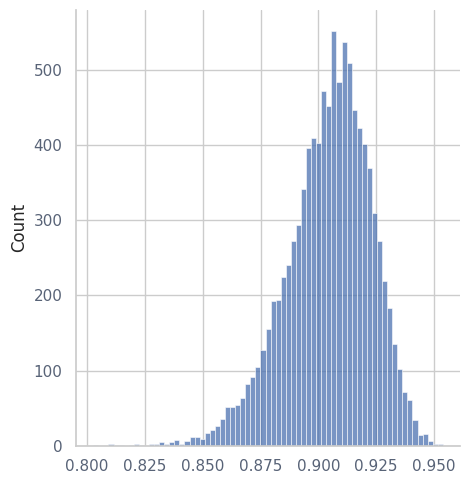

In [42]:
sns.displot(joint_score)

train single models

In [43]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
score_0 = single_model.score(Xs[0][n_samples_train:], Y[n_samples_train:])
score_0 = backend.to_numpy(score_0)

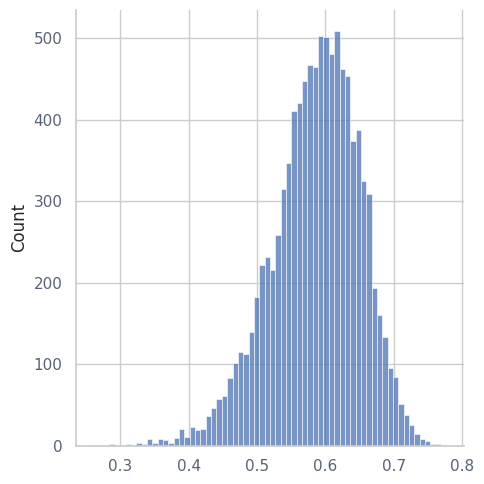

In [44]:
sns.displot(score_0)

In [45]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[1][:n_samples_train], Y[:n_samples_train])
score_1 = single_model.score(Xs[1][n_samples_train:], Y[n_samples_train:])
score_1 = backend.to_numpy(score_1)

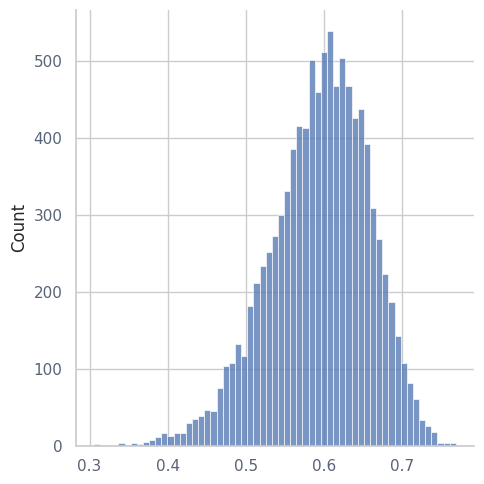

In [46]:
sns.displot(score_1)

Calculate unique and shared variance

In [47]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [48]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [49]:
scores = pd.DataFrame()
scores[r"$f(X_1\cup X_2)\approx Y$"] = joint_score
scores[r"$g(X_1)\approx Y$"] = score_0
scores[r"$h(X_2)\approx Y$"] = score_1
scores[r"$g(X_1)\cap h(X_2)$"] = shared
scores[r"$g(X_1) \setminus h(X_2)$"] = x0_unique
scores[r"$h(X_2) \setminus g(X_1)$"] = x1_unique
scores.head()

,$f(X_1\cup X_2)\approx Y$,$g(X_1)\approx Y$,$h(X_2)\approx Y$,$g(X_1)\cap h(X_2)$,$g(X_1) \setminus h(X_2)$,$h(X_2) \setminus g(X_1)$
0,0.873241,0.533933,0.431964,0.092656,0.441277,0.339308
1,0.919123,0.634543,0.666456,0.381875,0.252667,0.284581
2,0.909295,0.601196,0.631487,0.323389,0.277808,0.308099
3,0.916010,0.602299,0.607015,0.293304,0.308995,0.313711
4,0.919719,0.581759,0.529323,0.191363,0.390396,0.337960


Text(0.0, 1.0, 'Variance Partitioning')

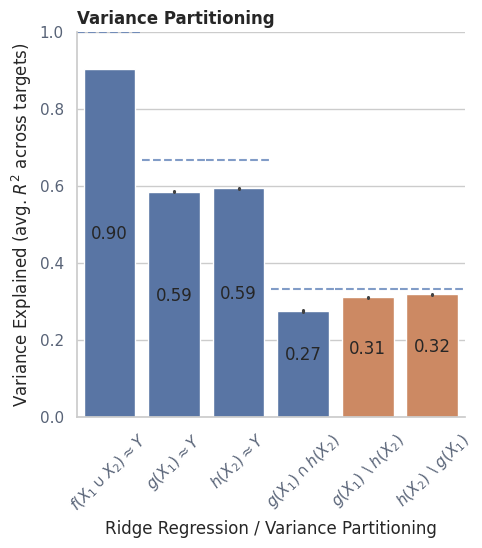

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.barplot(
    data=scores,
    palette=["C0", "C0", "C0", "C0", "C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax
)
sns.despine(fig)
theoretical_scores = [sum(scalars), scalars[0] + scalars[1], scalars[0] + scalars[2], scalars[0], scalars[1],
                      scalars[2]]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7,
                xmin=xmin, xmax=xmax, label=fr'Theoretically Explained Variance' if idx == 0 else "")

    plt.text(idx, scores[column].mean() / 2,
             f"{scores[column].mean():.2f}", ha='center', va='bottom')

plt.xticks(range(len(scores.columns)), scores.columns, rotation=45)

plt.ylim(0, 1)

# Ensure the legend is displayed properly
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel(r"Variance Explained (avg. $R^2$ across targets)")
plt.xlabel(r"Ridge Regression / Variance Partitioning")
plt.title("Variance Partitioning")